In [1]:
import os
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA

In [2]:
sys.path.append("../../src/.")
import plotting_functions as pf

In [3]:
DIR = "../../data/"
SUBWAYUS = "Subway USA/subway_usa_"

In [4]:
train_df = pd.read_csv(DIR + SUBWAYUS + "processed_train.csv", index_col="store")
test_df = pd.read_csv(DIR + SUBWAYUS + "processed_test.csv", index_col="store")

In [5]:
train_df.shape

(12944, 198)

In [6]:
def agg_inrix(df):
    inrix_columns = []
    for col in df.columns.tolist():
        if 'inrix_' in col:
            inrix_columns.append(col)
    df['inrix_total_ta'] = df[inrix_columns].sum(axis=1)
    df.drop(columns=inrix_columns, inplace=True)

agg_inrix(train_df)
agg_inrix(test_df)

In [7]:
result_df = pd.DataFrame([], index=train_df.index)

## PCA

### Test for Mininum Components to Capture 90% Variance

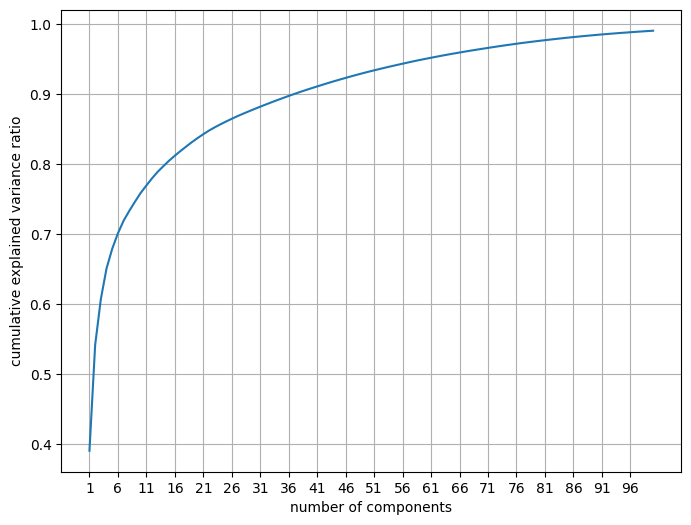

37

In [8]:
pf.pca_plot(train_df)

### PCA model (90% Variance) - Layer 1

In [9]:
pca = PCA(n_components=37, whiten=True, random_state=42)
pca.fit(train_df)

PCA(n_components=37, random_state=42, whiten=True)

In [10]:
transformed_features = pd.DataFrame(
    abs(pca.components_), 
    columns=train_df.columns.tolist(), 
    index=pca.get_feature_names_out(train_df.columns.tolist()))
transformed_features.head()

,dtpop_students_p_ta,emp_construction_p_ta,nces_private_schools_3mi,crime_total_index_ta,gq_military_p_ta,spend_dinner_ta,dtpop_students_prek_8th_p_ta,hispanic_p_ta,popgrfy_ta,com0811_p_ta,...,osm_highway_exits_count_1mi,occhu_ta,hh_expected_pers_ta,military_installations_1mi,osm_nearest_exit_dist,dmm_gla_3mi,ipeds_postsecondary_schools_1mi,market_size,store_density,inrix_total_ta
pca0,0.000446,0.006426,0.032108,0.018406,0.001093,0.038861,0.002042,0.027682,0.011538,0.012788,...,0.019440,0.039633,0.000127,0.003410,0.022111,0.039118,0.015228,0.082924,0.055967,0.949651
pca1,0.013284,0.027401,0.123055,0.041089,0.002625,0.107433,0.026331,0.022314,0.014004,0.005904,...,0.058251,0.115978,0.063831,0.007012,0.027842,0.074552,0.095995,0.097149,0.132897,0.276655
pca2,0.036448,0.063020,0.001876,0.105945,0.007052,0.029197,0.039026,0.040662,0.089361,0.055212,...,0.008948,0.011889,0.086005,0.003018,0.034066,0.023035,0.007340,0.175884,0.008003,0.067525
pca3,0.004315,0.078369,0.003373,0.033724,0.001023,0.103832,0.206298,0.147305,0.074071,0.068509,...,0.012676,0.053363,0.186138,0.007163,0.045435,0.010648,0.079032,0.188102,0.030350,0.070833
pca4,0.054974,0.008850,0.083968,0.139585,0.030243,0.010198,0.053771,0.035278,0.067533,0.026956,...,0.086399,0.020822,0.049541,0.022811,0.110868,0.128473,0.054575,0.210556,0.134736,0.093375


#### Filter and Count Important Features (of heavy weights)

Filter the values in the PCA component matrix, and count the occurrence of the features in the filtered matrix.

In [11]:
W = abs(pca.components_)
features = transformed_features.columns
long_results = []
for i in range(W.shape[0]):
    array = W[i]
    heavy_idx = np.where(array > 0.15)
    long_results += list(features[heavy_idx])

In [12]:
count = pd.Series(long_results).value_counts()
pca_features = count.index.tolist()
count

market_size                        11
emp_accommodation_foodserv_p_ta     7
emp_mining_p_ta                     7
gq_other_p_ta                       6
com0811_p_ta                        6
                                   ..
hh_type_female_nochild_p_ta         1
dmm_gla_3mi                         1
hh_expected_pers_ta                 1
pop_seasonal_ta                     1
hh_type_female_p_ta                 1
Name: count, Length: 126, dtype: int64

In [13]:
pca_feature_weight = pd.Series(np.sum(W, axis=0), index=transformed_features.columns)
pca_feature_weight.sort_values(ascending=False, inplace=True)
pca_feature_weight = pca_feature_weight.filter(items = pca_features, axis=0)
pca_feature_weight

market_size                        4.455642
emp_accommodation_foodserv_p_ta    2.759750
emp_mining_p_ta                    3.220806
gq_other_p_ta                      3.174840
com0811_p_ta                       2.894243
                                     ...   
hh_type_female_nochild_p_ta        1.816161
dmm_gla_3mi                        1.915055
hh_expected_pers_ta                1.414643
pop_seasonal_ta                    2.003080
hh_type_female_p_ta                1.846248
Length: 126, dtype: float64

In [14]:
important_features = pca_feature_weight.sort_values(ascending=False)[:40].index.tolist()

In [15]:
reduced_train = train_df[pca_features]
reduced_test = test_df[pca_features]
reduced_train

,market_size,emp_accommodation_foodserv_p_ta,emp_mining_p_ta,gq_other_p_ta,com0811_p_ta,emp_transportation_storage_p_ta,nces_public_schools_nearest_dist,emp_realestate_rentlease_p_ta,emp_information_p_ta,hh_type_male_child_p_ta,...,hrsa_number_of_certified_beds_2mi,white_p_ta,dmm_count_1mi,boomer_p_ta,dtpop_retired_disabled_p_ta,hh_type_female_nochild_p_ta,dmm_gla_3mi,hh_expected_pers_ta,pop_seasonal_ta,hh_type_female_p_ta
store,,,,,,,,,,,,,,,,,,,,,
6150300,2.0,0.514729,-0.329934,2.510505,3.304383,-0.317890,-0.719608,2.552759,-0.417453,1.104476,...,0.956087,-1.749451,-0.462636,-0.958444,0.150983,1.888641,-0.476042,-0.577592,-0.258713,1.756243
3784100,2.0,0.279105,-0.329934,1.338613,-1.035261,-0.664913,0.703190,0.277571,-0.479100,-0.646358,...,-0.352700,0.029789,0.637963,0.513045,1.579595,0.268583,0.104055,-0.636700,-0.317983,-0.046099
1192500,2.0,-0.685059,0.164295,-0.744864,-0.493172,-0.525511,-0.398347,-0.531032,-0.670206,-0.410199,...,-0.090942,0.457056,0.637963,0.920053,0.343997,-0.354001,1.071506,0.170248,0.003411,-0.276568
449400,4.0,-0.503601,-0.329934,-0.151132,-0.425777,-0.187386,-0.533603,-0.871913,-0.676371,0.208701,...,1.791965,0.363884,0.637963,0.522678,0.666195,0.007500,0.123331,0.202371,-0.136834,0.182570
2292700,0.0,-0.072977,-0.170505,-0.471355,1.090608,0.213025,-0.303830,-0.324917,-0.676371,-0.304334,...,0.130679,-1.577531,-0.462636,-0.683895,-0.379428,1.256015,1.200005,-1.572142,-0.308800,0.341018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440100,4.0,0.566187,0.307781,-0.682918,-0.920983,-0.220012,-0.805969,-0.832276,-0.941453,-0.336908,...,-0.352700,1.167739,-0.462636,1.630510,1.350106,0.318792,-0.570754,0.548022,-0.260383,-0.204546
6487000,4.0,0.785562,-0.186448,-0.743172,-0.836007,-0.608559,0.241304,0.095239,-0.959947,0.404143,...,-0.324779,-0.164352,-0.462636,-0.199821,-0.596759,-0.056098,0.530017,0.077731,-0.271235,0.314010
2493300,1.0,0.094939,-0.329934,-0.614203,1.317699,0.284209,0.398550,0.562961,-0.688700,-0.157753,...,-0.352700,1.018819,-0.462636,0.903194,0.678354,-0.745626,1.075440,0.386119,-0.094260,-0.508838


In [16]:
def corr_pair(target_corr, corr_threshold=0.6):
    np.fill_diagonal(target_corr.values, 0)
    sorted_pair = target_corr.abs().unstack().sort_values(kind="quicksort", ascending=False)
    return sorted_pair[sorted_pair > corr_threshold]

correlated_pairs = corr_pair(reduced_train.corr())

In [17]:
correlated_pairs[:20:2]

hh_type_1pers_p_ta                  hh_expected_pers_ta            1.000000
emp_military_ta                     occ_military_p_ta              1.000000
pop5y_cagr_ta                       popgrpy_ta                     0.999096
hhgrfypy_ta                         popgrfy_ta                     0.998156
hh_inc_gt_75k_p_ta                  hh_inc_lt_75k_p_ta             0.998023
hhgrpycy_ta                         popgrpy_ta                     0.997022
dtpop_students_post_secondary_p_ta  dtpop_students_p_ta            0.996903
pop5y_cagr_ta                       hhgrpycy_ta                    0.996545
dtpop_students_prek_8th_p_ta        dtpop_children_at_home_p_ta    0.991309
disposable_inc_avg_ta               hhinc100pl_p_ta                0.989117
dtype: float64

In [18]:
def corr_pair_drop(feature_pairs, corr_with_target):
    selected, discarded = [], []
    for f1, f2 in feature_pairs:
        if abs(corr_with_target[f1]) < abs(corr_with_target[f2]):
            selected.append(f2)
            discarded.append(f1)
        else:
            selected.append(f1)
            discarded.append(f2)
    final_discarded = set(discarded) - set(selected) 
    return list(final_discarded)

In [19]:
corr_drop_list = corr_pair_drop(correlated_pairs.index, pca_feature_weight)

In [20]:
important_features = list(set(important_features) - set(corr_drop_list))

In [21]:
reduced_train.drop(columns=corr_drop_list, inplace=True)
reduced_test.drop(columns=corr_drop_list, inplace=True)

/var/folders/t1/c4fmzstn5v92jwsl8z5vhpp40000gn/T/ipykernel_87596/1625573170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_train.drop(columns=corr_drop_list, inplace=True)
/var/folders/t1/c4fmzstn5v92jwsl8z5vhpp40000gn/T/ipykernel_87596/1625573170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_test.drop(columns=corr_drop_list, inplace=True)


In [22]:
correlated_pairs = corr_pair(reduced_train.corr())
correlated_pairs[:20:2]

hh_type_1pers_p_ta            hh_expected_pers_ta            1.000000
emp_military_ta               occ_military_p_ta              1.000000
pop5y_cagr_ta                 popgrpy_ta                     0.999096
hhgrfypy_ta                   popgrfy_ta                     0.998156
dtpop_students_prek_8th_p_ta  dtpop_children_at_home_p_ta    0.991309
hhinc100pl_p_ta               disposable_inc_avg_ta          0.989117
disposable_inc_avg_ta         medhhinc_ta                    0.984030
medhhinc_ta                   hhinc100pl_p_ta                0.978550
disposable_inc_avg_ta         hhinc150pl_p_ta                0.976828
hhinc150pl_p_ta               avghhinc_ta                    0.975691
dtype: float64

### PCA model (90% Variance) - Layer 2

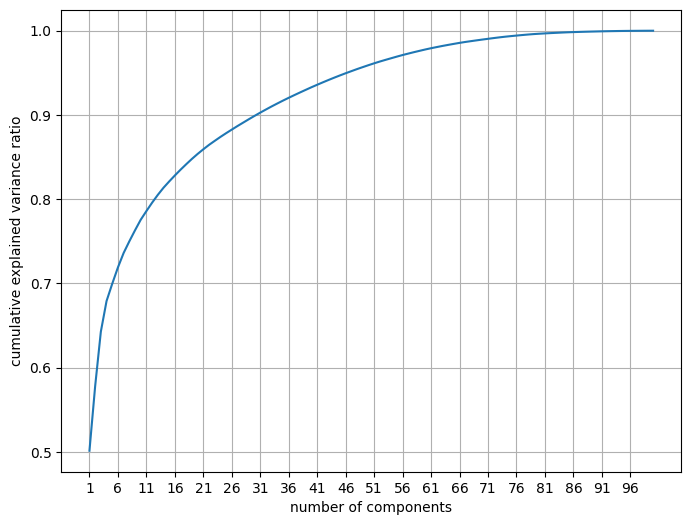

31

In [23]:
pf.pca_plot(reduced_train)

In [24]:
pca_2 = PCA(n_components=29, whiten=True, random_state=42)
pca_2.fit(reduced_train)

PCA(n_components=29, random_state=42, whiten=True)

In [25]:
transformed_features = pd.DataFrame(
    abs(pca_2.components_), 
    columns=reduced_train.columns.tolist(), 
    index=pca_2.get_feature_names_out(reduced_train.columns.tolist()))
transformed_features.head()

,market_size,emp_accommodation_foodserv_p_ta,emp_mining_p_ta,gq_other_p_ta,com0811_p_ta,emp_transportation_storage_p_ta,nces_public_schools_nearest_dist,emp_realestate_rentlease_p_ta,emp_information_p_ta,hh_type_male_child_p_ta,...,com0002_p_ta,hrsa_hospitals_2mi,mortgage_avgrisk_ta,dmm_count_1mi,dtpop_retired_disabled_p_ta,hh_type_female_nochild_p_ta,dmm_gla_3mi,hh_expected_pers_ta,pop_seasonal_ta,hh_type_female_p_ta
pca0,0.074868,0.004171,0.004160,0.010609,0.012115,0.001070,0.005347,0.016834,0.005193,0.002499,...,0.015303,0.011608,0.030930,0.019905,0.017516,0.013337,0.033132,0.004584,0.003365,0.008338
pca1,0.265984,0.008708,0.028246,0.033440,0.048623,0.030020,0.027147,0.026922,0.054420,0.086373,...,0.001365,0.073242,0.091689,0.087560,0.035361,0.085751,0.116291,0.027426,0.062750,0.118074
pca2,0.039220,0.028246,0.010124,0.030914,0.052088,0.034414,0.045632,0.002485,0.047857,0.008491,...,0.145415,0.164949,0.042140,0.085825,0.123836,0.064928,0.099874,0.207951,0.054819,0.080693
pca3,0.342056,0.030944,0.024846,0.074674,0.078961,0.024863,0.072468,0.024782,0.033911,0.110096,...,0.130991,0.020120,0.146821,0.014587,0.116576,0.196633,0.073917,0.137316,0.072108,0.209657
pca4,0.223339,0.003905,0.031619,0.079765,0.145289,0.041509,0.017509,0.058182,0.018441,0.004989,...,0.118250,0.104406,0.010900,0.001568,0.147733,0.115806,0.067551,0.018249,0.023527,0.081411


#### Filter and Count Important Features (of heavy weights)

Filter the values in the PCA component matrix, and count the occurrence of the features in the filtered matrix.

In [26]:
W = abs(pca_2.components_)
features = transformed_features.columns
long_results = []
for i in range(W.shape[0]):
    array = W[i]
    heavy_idx = np.where(array > 0.15)
    long_results += list(features[heavy_idx])

In [27]:
count = pd.Series(long_results).value_counts()
count

market_size                        10
emp_unknown_ta                      8
emp_accommodation_foodserv_p_ta     7
emp_mining_p_ta                     7
other_p_ta                          7
                                   ..
nces_private_schools_2mi            1
emp_p_ta                            1
hu_ownerocc_ta                      1
dmm_count_2mi                       1
popgr10cn_ta                        1
Name: count, Length: 107, dtype: int64

In [28]:
pca_2_features = count.index.tolist()

In [29]:
pca_2_feature_weight = pd.Series(np.sum(W, axis=0), index=transformed_features.columns)
pca_2_feature_weight.sort_values(ascending=False, inplace=True)
pca_2_feature_weight = pca_feature_weight.filter(items=pca_2_features, axis=0)
pca_2_feature_weight

market_size                        4.455642
emp_unknown_ta                     2.457841
emp_accommodation_foodserv_p_ta    2.759750
emp_mining_p_ta                    3.220806
other_p_ta                         3.055416
                                     ...   
nces_private_schools_2mi           1.536860
emp_p_ta                           1.815959
hu_ownerocc_ta                     2.048227
dmm_count_2mi                      1.656432
popgr10cn_ta                       2.389694
Length: 107, dtype: float64

In [30]:
pca_2_feature_weight = pca_2_feature_weight.sort_values(ascending=False)
important_features_2 = pca_2_feature_weight[:40].index.tolist()

In [31]:
important_features = list(set(important_features + important_features_2))

In [32]:
reduced_train = reduced_train[important_features]
reduced_test = reduced_test[important_features]
reduced_train

,emp_retail_trade_p_ta,emp_accommodation_foodserv_p_ta,emp_other_p_ta,emp_construction_p_ta,emp_arts_entertainment_p_ta,gq_other_p_ta,emp_information_p_ta,nces_public_schools_nearest_dist,com0508_p_ta,osm_nearest_exit_dist,...,military_installations_1mi,hh_type_male_child_p_ta,other_p_ta,black_p_ta,emp_healthcare_social_assistance_p_ta,market_size,popgr10cn_ta,emp_finance_insurance_p_ta,centerxy_gla_effective_1mi,military_installations_2mi
store,,,,,,,,,,,,,,,,,,,,,
6150300,-0.145172,0.514729,1.150215,-0.746650,-0.759556,2.510505,-0.417453,-0.719608,-0.701691,-0.425379,...,-0.082631,1.104476,-0.352255,-0.325387,-1.144059,2.0,-0.248036,-0.739929,-0.256146,-0.157237
3784100,1.904535,0.279105,1.035338,0.792276,-1.021983,1.338613,-0.479100,0.703190,0.636829,-0.360187,...,-0.082631,-0.646358,0.213035,0.081633,-0.368062,2.0,0.285237,-0.817860,1.723525,-0.157237
1192500,1.520590,-0.685059,-0.877818,-0.421430,-0.514243,-0.744864,-0.670206,-0.398347,-0.445058,-0.301741,...,-0.082631,-0.410199,0.068600,-0.472435,0.409110,2.0,-0.241841,-0.705293,0.154141,-0.157237
449400,0.564727,-0.503601,-0.595042,-0.920995,-0.428669,-0.151132,-0.676371,-0.533603,-0.295355,-0.021385,...,-0.082631,0.208701,-0.399570,-0.546890,0.817096,4.0,-0.117522,-0.618703,0.393452,-0.157237
2292700,-0.447129,-0.072977,-0.016235,0.715162,1.385502,-0.471355,-0.676371,-0.303830,-0.715530,-0.185947,...,-0.082631,-0.304334,-0.250154,-0.654849,-0.090585,0.0,-0.187331,-0.185753,-0.525824,-0.157237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440100,-1.532973,0.566187,0.372582,-0.552189,0.016316,-0.682918,-0.941453,-0.805969,-0.699175,-0.383242,...,-0.082631,-0.336908,-0.334823,-0.551233,1.290924,4.0,-0.299179,-0.558090,-0.525824,-0.157237
6487000,1.040658,0.785562,0.200265,-0.495192,1.134485,-0.743172,-0.959947,0.241304,0.394034,-0.376830,...,-0.082631,0.404143,-0.299959,1.251193,1.018149,4.0,0.038132,-0.471500,-0.302685,-0.157237
2493300,-0.247157,0.094939,-0.422726,-0.495192,-0.867950,-0.614203,-0.688700,0.398550,0.626765,-0.320988,...,-0.082631,-0.157753,-0.302450,-0.649885,1.807079,1.0,-0.235070,-0.488818,0.050008,-0.157237


In [33]:
def corr_pair(target_corr, corr_threshold=0.6):
    np.fill_diagonal(target_corr.values, 0)
    sorted_pair = target_corr.abs().unstack().sort_values(kind="quicksort", ascending=False)
    return sorted_pair[sorted_pair > corr_threshold]

correlated_pairs = corr_pair(reduced_train.corr())

In [34]:
correlated_pairs[:20:2]

dmm_gla_1mi                        dmm_count_1mi                  0.887327
osm_highway_exits_count_2mi        osm_highway_exits_count_1mi    0.797723
hrsa_number_of_certified_beds_1mi  hrsa_hospitals_1mi             0.794156
dmm_gla_1mi                        centerxy_gla_effective_1mi     0.778494
dmm_count_1mi                      centerxy_gla_effective_1mi     0.743188
com0508_p_ta                       com12pl_p_ta                   0.672476
dmm_nearest_dist                   osm_nearest_exit_dist          0.600994
dtype: float64

In [35]:
print(pca_feature_weight['centerxy_gla_effective_1mi'], pca_feature_weight['dmm_gla_1mi'])
print(pca_feature_weight['osm_highway_exits_count_2mi'], pca_feature_weight['osm_highway_exits_count_1mi'])

2.415554624512189 2.747754094396915
2.4119125435719666 2.5321120512930153


In [36]:
corr_drop_list = ['dmm_count_1mi', 'dmm_gla_1mi', 'osm_highway_exits_count_1mi', 'hrsa_hospitals_1mi']

In [37]:
reduced_train.drop(columns=corr_drop_list, inplace=True)
reduced_test.drop(columns=corr_drop_list, inplace=True)

/var/folders/t1/c4fmzstn5v92jwsl8z5vhpp40000gn/T/ipykernel_87596/1625573170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_train.drop(columns=corr_drop_list, inplace=True)


In [38]:
correlated_pairs = corr_pair(reduced_train.corr())
correlated_pairs[:100:2]

com12pl_p_ta      com0508_p_ta             0.672476
dmm_nearest_dist  osm_nearest_exit_dist    0.600994
dtype: float64

## Hierachical Clustering

### complete linkage

In [39]:
from scipy.cluster.hierarchy import (
    average,
    complete,
    fcluster,
    single,
    ward,
)

In [40]:
linkage_array = complete(train_df)
hier_labels = fcluster(linkage_array, 8, criterion="maxclust") 

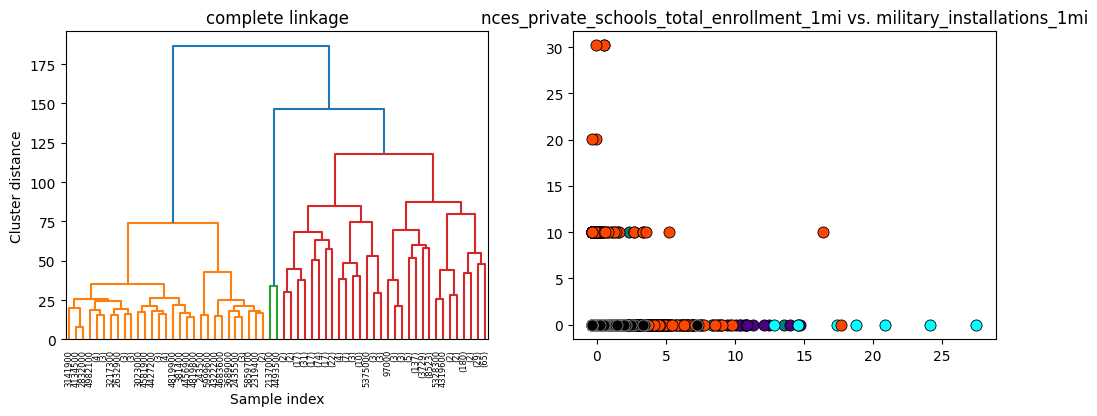

In [41]:
pf.plot_dendrogram_clusters(
    train_df, 
    linkage_array, 
    hier_labels, 
    p=6, 
    linkage_type='complete', 
    axis_0="nces_private_schools_total_enrollment_1mi",
    axis_1="military_installations_1mi",
    title="nces_private_schools_total_enrollment_1mi vs. military_installations_1mi"
)

In [42]:
result_df['complete label'] = hier_labels 

In [43]:
unique, counts = np.unique(hier_labels, return_counts=True)
dict(zip(unique, counts))

{1: 46, 2: 2, 3: 182, 4: 24, 5: 7, 6: 12401, 7: 6, 8: 276}

---
### ward linkage

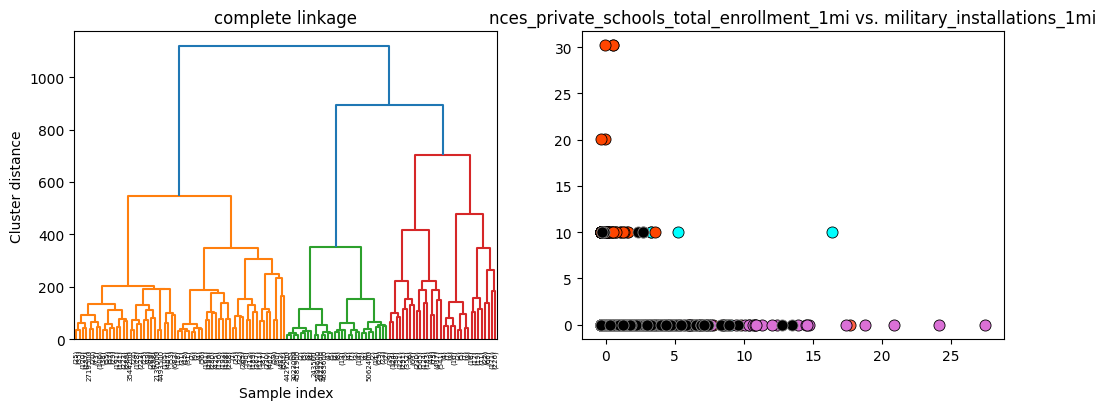

In [44]:
linkage_array = ward(train_df)
hier_labels = fcluster(linkage_array, 8, criterion="maxclust")
pf.plot_dendrogram_clusters(
    train_df,
    linkage_array, 
    hier_labels, 
    p=6, 
    linkage_type='complete', 
    axis_0="nces_private_schools_total_enrollment_1mi",
    axis_1="military_installations_1mi",
    title="nces_private_schools_total_enrollment_1mi vs. military_installations_1mi"
)

In [45]:
result_df['ward label'] = hier_labels 

In [46]:
unique, counts = np.unique(hier_labels, return_counts=True)
dict(zip(unique, counts))

{1: 3727, 2: 5103, 3: 38, 4: 127, 5: 1094, 6: 2204, 7: 41, 8: 610}

---
### complete linkage with reduced data


In [47]:
reduced_linkage_array = complete(reduced_train)
reduced_hier_labels = fcluster(reduced_linkage_array, 8, criterion="maxclust") 

In [48]:
result_df['complet with reduced'] = reduced_hier_labels

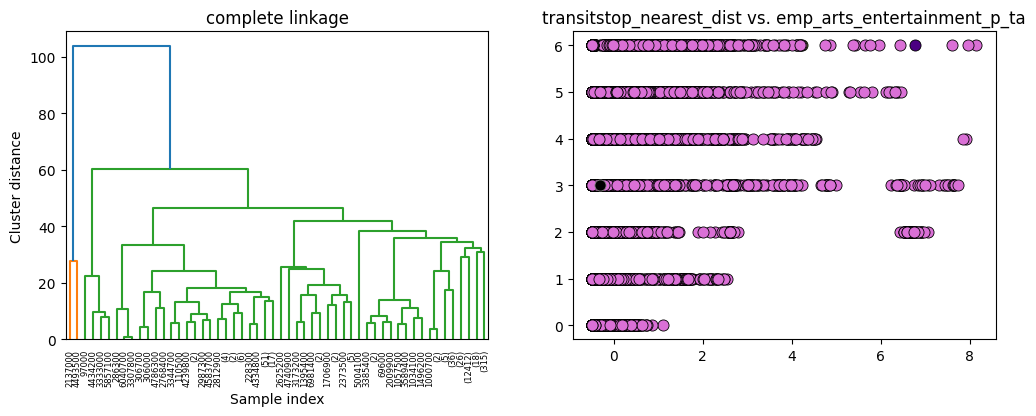

In [49]:
pf.plot_dendrogram_clusters(
    reduced_train, 
    reduced_linkage_array, 
    reduced_hier_labels, 
    p=8, 
    linkage_type='complete', 
    axis_0="transitstop_nearest_dist",
    axis_1="market_size",
    title="transitstop_nearest_dist vs. emp_arts_entertainment_p_ta"
)

In [50]:
unique, counts = np.unique(reduced_hier_labels, return_counts=True)
dict(zip(unique, counts))

{1: 2, 2: 4, 3: 97, 4: 16, 5: 9, 6: 44, 7: 12771, 8: 1}

---
### ward linkage with reduced data

In [51]:
reduced_linkage_array = ward(reduced_train)
reduced_hier_labels = fcluster(reduced_linkage_array, 8, criterion="maxclust") 

In [52]:
result_df['ward with reduced'] = reduced_hier_labels

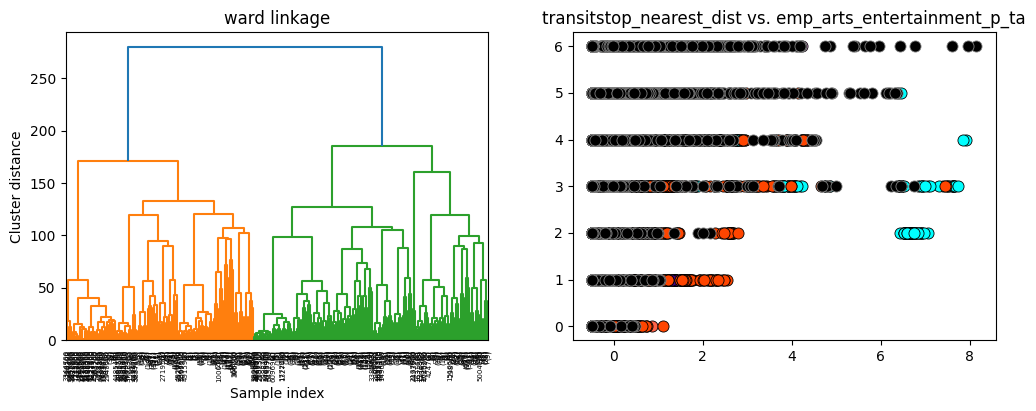

In [53]:
pf.plot_dendrogram_clusters(
    reduced_train, 
    reduced_linkage_array, 
    reduced_hier_labels, 
    p=8, 
    linkage_type='ward', 
    axis_0="transitstop_nearest_dist",
    axis_1="market_size",
    title="transitstop_nearest_dist vs. emp_arts_entertainment_p_ta"
)

In [54]:
unique, counts = np.unique(reduced_hier_labels, return_counts=True)
dict(zip(unique, counts))

{1: 94, 2: 1735, 3: 150, 4: 4409, 5: 1677, 6: 2869, 7: 2, 8: 2008}

---
### complete linkage with PCA reduced data (1 layer)

In [55]:
pca_train = pca.transform(train_df)
pca_train = pd.DataFrame(pca_train, index=train_df.index, columns=pca.get_feature_names_out(train_df.columns.tolist()))
linkage_arra_pca = complete(pca_train)
hier_labels_pca = fcluster(linkage_arra_pca, 8, criterion="maxclust") 

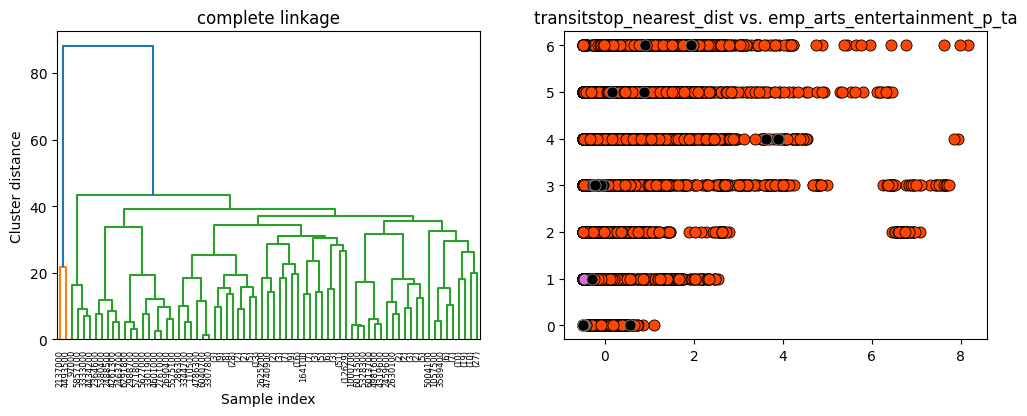

In [56]:
pf.plot_dendrogram_clusters(
    train_df,
    linkage_arra_pca, 
    hier_labels_pca, 
    p=8, 
    linkage_type='complete', 
    axis_0="transitstop_nearest_dist",
    axis_1="market_size",
    title="transitstop_nearest_dist vs. emp_arts_entertainment_p_ta"
)

In [57]:
result_df['complete with PCA'] = hier_labels_pca

In [58]:
unique, counts = np.unique(hier_labels_pca, return_counts=True)
dict(zip(unique, counts))

{1: 2, 2: 4, 3: 5, 4: 9, 5: 76, 6: 12744, 7: 22, 8: 82}

---
### ward linkage with PCA reduced data (1 layer)

In [59]:
linkage_arra_pca = ward(pca_train)
hier_labels_pca = fcluster(linkage_arra_pca, 8, criterion="maxclust") 

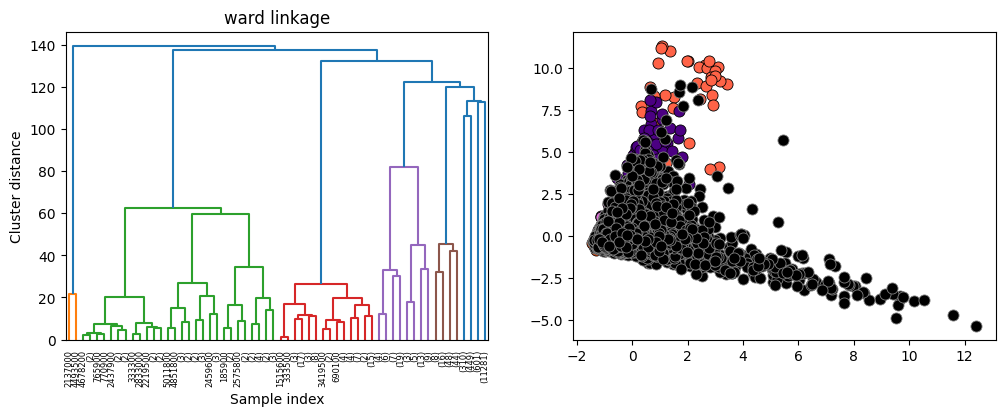

In [60]:
pf.plot_dendrogram_clusters(
    pca_train, 
    linkage_arra_pca, 
    hier_labels_pca, 
    p=6, 
    linkage_type='ward', 
    axis_0="pca0",
    axis_1="pca1"
    # axis_0="transitstop_nearest_dist",
    # axis_1="market_size",
    # title="transitstop_nearest_dist vs. market_size"
)

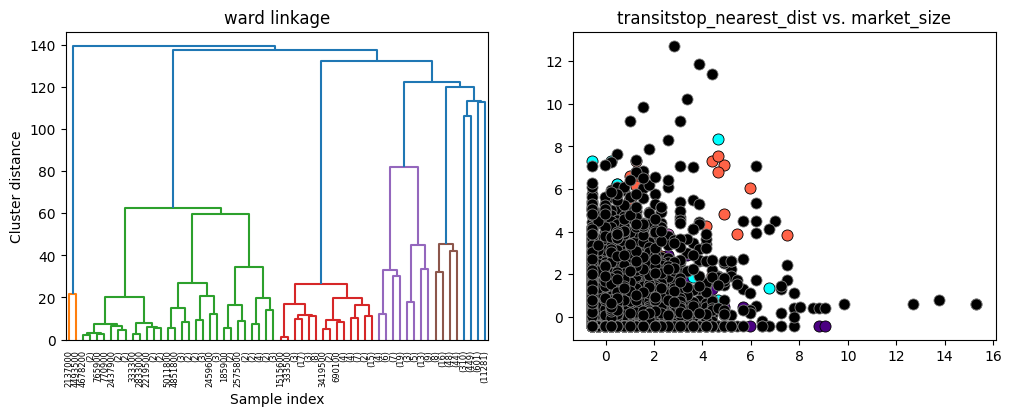

In [61]:
pf.plot_dendrogram_clusters(
    train_df, 
    linkage_arra_pca, 
    hier_labels_pca, 
    p=6, 
    linkage_type='ward', 
    title="transitstop_nearest_dist vs. market_size"
)

In [62]:
result_df['ward with PCA'] = hier_labels_pca

In [63]:
unique, counts = np.unique(hier_labels_pca, return_counts=True)
dict(zip(unique, counts))

{1: 2, 2: 50, 3: 69, 4: 66, 5: 116, 6: 759, 7: 601, 8: 11281}

In [66]:
result_df.head()

,complete label,ward label,complet with reduced,ward with reduced,complete with PCA,ward with PCA
store,,,,,,
6150300,6,2,7,2,6,8
3784100,6,6,7,6,6,8
1192500,6,2,7,6,6,8
449400,6,2,7,5,6,8
2292700,6,5,7,2,6,8


## DBSCAN

In [65]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.1, min_samples=3).fit(train_df)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 0
Estimated number of noise points: 12944
